Saving 2.alzheimers.csv to 2.alzheimers (1).csv


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [13:15:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[모델 성능 비교 요약표]


,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,Logistic Regression,0.847826,0.815534,0.736842,0.774194,0.888327
1,Random Forest,0.934783,0.969697,0.842105,0.901408,0.932861
2,SVM (RBF),0.860248,0.841584,0.745614,0.790698,0.911775
3,XGBoost (Bayesian),0.944099,0.952830,0.885965,0.918182,0.943657


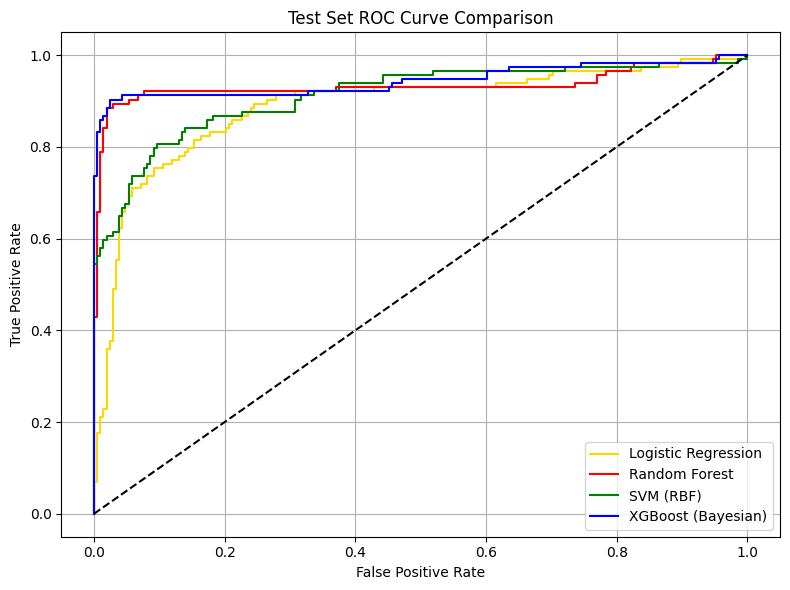

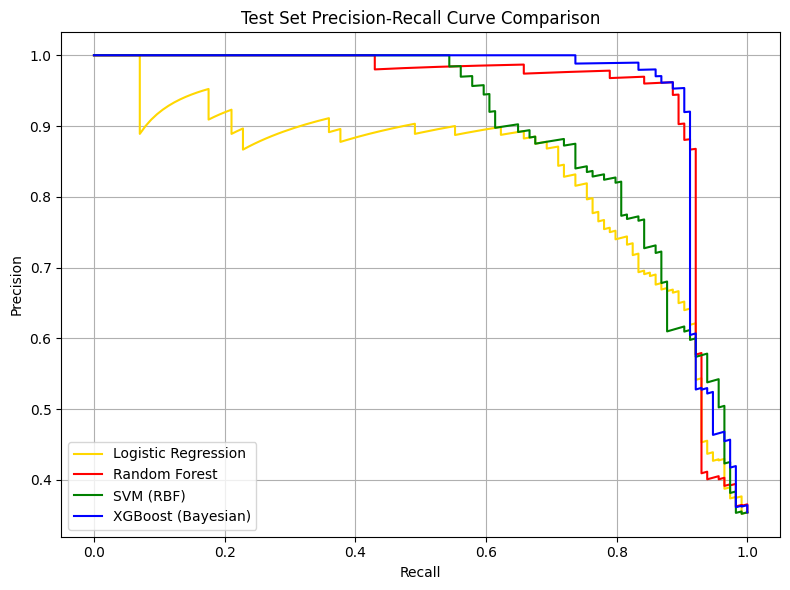

In [1]:
# 알츠하이머 진단을 위한 머신러닝 모델링 파이프라인
# Google Colab 환경용 (필요시 pip 설치 포함)

# 1. 설치
!pip install xgboost scikit-optimize shap -q

# 2. 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve, precision_recall_curve)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier, plot_importance
from skopt import BayesSearchCV
from skopt.space import Real, Integer

# 3. 데이터 로드 (Colab 업로드 방식 사용)
from google.colab import files
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)

# 4. 전처리 및 파생 변수 생성
data = df.drop(columns=["PatientID", "DoctorInCharge"], errors='ignore').copy()
data = data[(data['BMI'] >= 15) & (data['BMI'] <= 40)]
data = data[(data['MMSE'] >= 0) & (data['MMSE'] <= 30)]
data = data[(data['SystolicBP'] >= 90) & (data['SystolicBP'] <= 200)]
data = data[(data['DiastolicBP'] >= 50) & (data['DiastolicBP'] <= 120)]
data = pd.get_dummies(data, columns=['Gender', 'Ethnicity', 'EducationLevel'], drop_first=True)

scaler = StandardScaler()
continuous_vars = data.select_dtypes(include=['float64', 'int64']).drop(columns=['Diagnosis']).columns
data_scaled = data.copy()
data_scaled[continuous_vars] = scaler.fit_transform(data[continuous_vars])
data_scaled['CardioRisk'] = df['Hypertension'] + df['Diabetes'] + (df['CholesterolTotal'] > 240).astype(int)
data_scaled['CognitiveScore'] = df['MMSE'] + df['ADL'] + df['FunctionalAssessment']
data_scaled = pd.get_dummies(data_scaled, columns=['CardioRisk'], drop_first=True)
data_scaled['Diagnosis'] = data['Diagnosis'].values

train, test_val = train_test_split(data_scaled, test_size=0.3, stratify=data_scaled['Diagnosis'], random_state=42)
val, test = train_test_split(test_val, test_size=0.5, stratify=test_val['Diagnosis'], random_state=42)
X_train, y_train = train.drop(columns=["Diagnosis"]), train["Diagnosis"]
X_val, y_val = val.drop(columns=["Diagnosis"]), val["Diagnosis"]
X_test, y_test = test.drop(columns=["Diagnosis"]), test["Diagnosis"]
X_val = X_val.reindex(columns=X_train.columns, fill_value=0)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# 5. 모델 정의 및 훈련 함수 정의
def train_and_evaluate_model(model, name, X_val, y_val):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    y_prob = model.predict_proba(X_val)[:, 1]
    return {
        "Model": name,
        "Accuracy": accuracy_score(y_val, y_pred),
        "Precision": precision_score(y_val, y_pred),
        "Recall": recall_score(y_val, y_pred),
        "F1 Score": f1_score(y_val, y_pred),
        "AUC": roc_auc_score(y_val, y_prob),
        "fpr": roc_curve(y_val, y_prob)[0],
        "tpr": roc_curve(y_val, y_prob)[1],
        "prec": precision_recall_curve(y_val, y_prob)[0],
        "rec": precision_recall_curve(y_val, y_prob)[1]
    }

# 6. 모델 학습
results = []
results.append(train_and_evaluate_model(LogisticRegression(max_iter=1000), "Logistic Regression", X_val, y_val))
results.append(train_and_evaluate_model(RandomForestClassifier(n_estimators=300, max_depth=20, min_samples_leaf=2, random_state=42), "Random Forest", X_val, y_val))
results.append(train_and_evaluate_model(SVC(probability=True, kernel='rbf', C=10, gamma=0.01), "SVM (RBF)", X_val, y_val))
results.append(train_and_evaluate_model(XGBClassifier(use_label_encoder=False, eval_metric='logloss', learning_rate=0.07, n_estimators=500, max_depth=5, min_child_weight=2, subsample=0.92, colsample_bytree=0.95, random_state=42), "XGBoost (Bayesian)", X_val, y_val))

# 7. 성능 비교 테이블 출력
perf_df = pd.DataFrame([{k: v for k, v in r.items() if k not in ['fpr', 'tpr', 'prec', 'rec']} for r in results])
print("\n[모델 성능 비교 요약표]")
display(perf_df)

# 8. ROC Curve 시각화
colors = ['gold', 'red', 'green', 'blue']
plt.figure(figsize=(8, 6))
for r, color in zip(results, colors):
    plt.plot(r['fpr'], r['tpr'], label=r['Model'], color=color)
plt.plot([0, 1], [0, 1], 'k--')
plt.title("Test Set ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 9. Precision-Recall Curve 시각화
plt.figure(figsize=(8, 6))
for r, color in zip(results, colors):
    plt.plot(r['rec'], r['prec'], label=r['Model'], color=color)
plt.title("Test Set Precision-Recall Curve Comparison")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
